# Defining QoIs and running the MITgcm adjoint model to obtain adjoint sensitivity matrices

The process of differentiating and compiling MITgcm to obtain its adjoint, as well as running the compiled adjoint with generic QoIs, is described in `ECCO_adjoint_instructions.pdf` Section 3.
Our adjoint experiments use a CORE normal year forced version of the ECCOv4r4 configuration. Forcing, restart, and namelist files specific to this version can be found at https://doi.org/10.5281/zenodo.7814839

In order to define the QoI in a way that can be read by the adjoint, we need to edit the `data.ecco` namelist file, telling it which type of QoI we are interested in. We also need to provide masks in binary MDS format to tell the model where and when to evaluate the QoI. This is described in more detail [in the MITgcm manual](https://mitgcm.readthedocs.io/en/latest/ocean_state_est/ocean_state_est.html#generic-cost-function), as well as Section 3.1.2 of `ECCO_adjoint_instructions.pdf`.

This notebook defines space and time masks and provides the `data.ecco` file used for our QoI, then writes MDS mask files to be read by the model. These masks can also be used to diagnose QoI values from regular MITgcm output, by applying them to the THETA variable and integrating over volume.

The script `ADJ_to_netcdf.py` can be used to convert standard MITgcm adjoint output to netCDF format.

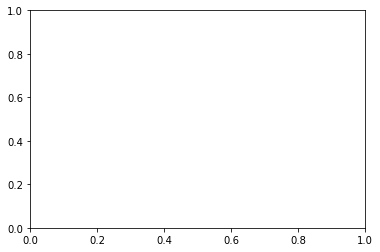

In [3]:
from DPC_functions import *

# Prepare and save QoI masks
## Spatial masks

In [ ]:
# Can get this file from https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/nctiles_grid
GDS=xr.open_dataset('~/ECCO-GRID.nc')

################################################################################                                                                                                                       
# Can either run the ECCOv4r4_reproduction to obtain ECCOv4r4_SSH_monthly.nc or download from
# https://ecco.jpl.nasa.gov/drive/files/Version4/Release4/nctiles_monthly/SSH and concatenate
DH=xr.open_dataset('ECCOv4r4_SSH_monthly.nc').SSH.mean('time').values

# Get surface mask of the Atlantic ocean
atlmsk=ecco.get_basin_mask(['atl','mexico'],GDS.hFacC,less_output=True)
ohcmsk2d=atlmsk.isel(k=0).values.copy()

# delete locations where latitude < 0, longitude > -18, and climatological DH>-0.7m
ohcmsk2d[GDS.YC.values<0]=0
ohcmsk2d[GDS.XC.values>-18]=0
ohcmsk2d[DH>-0.7]=0

# Create a vertical mask (50 levels) and delete below level 26 (~700m)
zmsk=np.ones(50)
zmsk[26:]=0

# Combine two masks to make a single 3d mask
ohcmsk=(ohcmsk2d*zmsk[:,None,None,None])
# Convert to an xarray DataArray to ensure compatibility with MDS writing functions
ohcmsk=(xr.ones_like(atlmsk)*ohcmsk)

# Get volume of unmasked area (ecco will calculate QoI in K, can use volume to return to J)
dVC=GDS.rA.expand_dims({'k':50})*GDS.drF*ohcmsk
voltot=dVC.values.sum()

with open('SPG_UOHC_MASK.info','wt') as infofile:
    infostr=('Mask file to be read by ECCO package gencost routines: \n'+\
             'Ocean heat content in region defined by largest closed negative dynamic height contour'+\
             'following Foukal and Lozier (2017) definition of the SPG, from 0-700m'+\
             'Volume of unmasked gridcells:'+str(voltot))
    infofile.write(infostr)


extra_metadata=xm.utils.get_extra_metadata(domain='llc',nx=90)
print('converting to standard LLC layout (5 faces)')
facets=xm.utils.rebuild_llc_facets(ohcmsk.rename({'tile':'face'}),extra_metadata)
print('converting to flat vector')
compact=xm.utils.llc_facets_3d_spatial_to_compact(facets,'k',extra_metadata=extra_metadata)
print('writing output')
xm.utils.write_to_binary(compact,'SPG_UOHC_MASKC')
xm.utils.write_to_binary(zmsk,'SPG_UOHC_MASKK')

## Temporal mask

In [ ]:
periods=600 #600 months in a 50 year run
cfprds=12   #12 months over which we want to average our QoI
timmsk=np.zeros(periods)
timmsk[-cfprds:]=1

xm.utils.write_to_binary(timmsk,'SPG_UOHC_MASKT')

# Namelist to run: `data.ecco`


```
# *******************
# ECCO cost functions
# *******************
 &ECCO_COST_NML
 &
# ***************************
# ECCO generic cost functions 
# ***************************
 &ECCO_GENCOST_NML
# OHC
 gencost_name(1) = 'OHC',
 gencost_barfile(1) = 'm_boxmean_theta',
 gencost_avgperiod(1) = 'month',
 gencost_msk_is3d(1)=.TRUE.,
 gencost_outputlevel(1) = 1,
 gencost_mask(1) = 'SPG_UOHC_MASK'
 mult_gencost(1) = 1,
#
 &
#

```